# Project 2 - Advanced Lane Finding

## 1. Camera Calibration

### 1.1. Perform calibration

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

# prepare object points
nx = 9
ny = 6
objpoints = []
imgpoints = []

objp = np.zeros((ny*nx, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
gray = None

for fname in glob.glob("./camera_cal/calibration*.jpg"):
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, append to imgpoints
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


## 2. Test calibration (Distortion Correction)

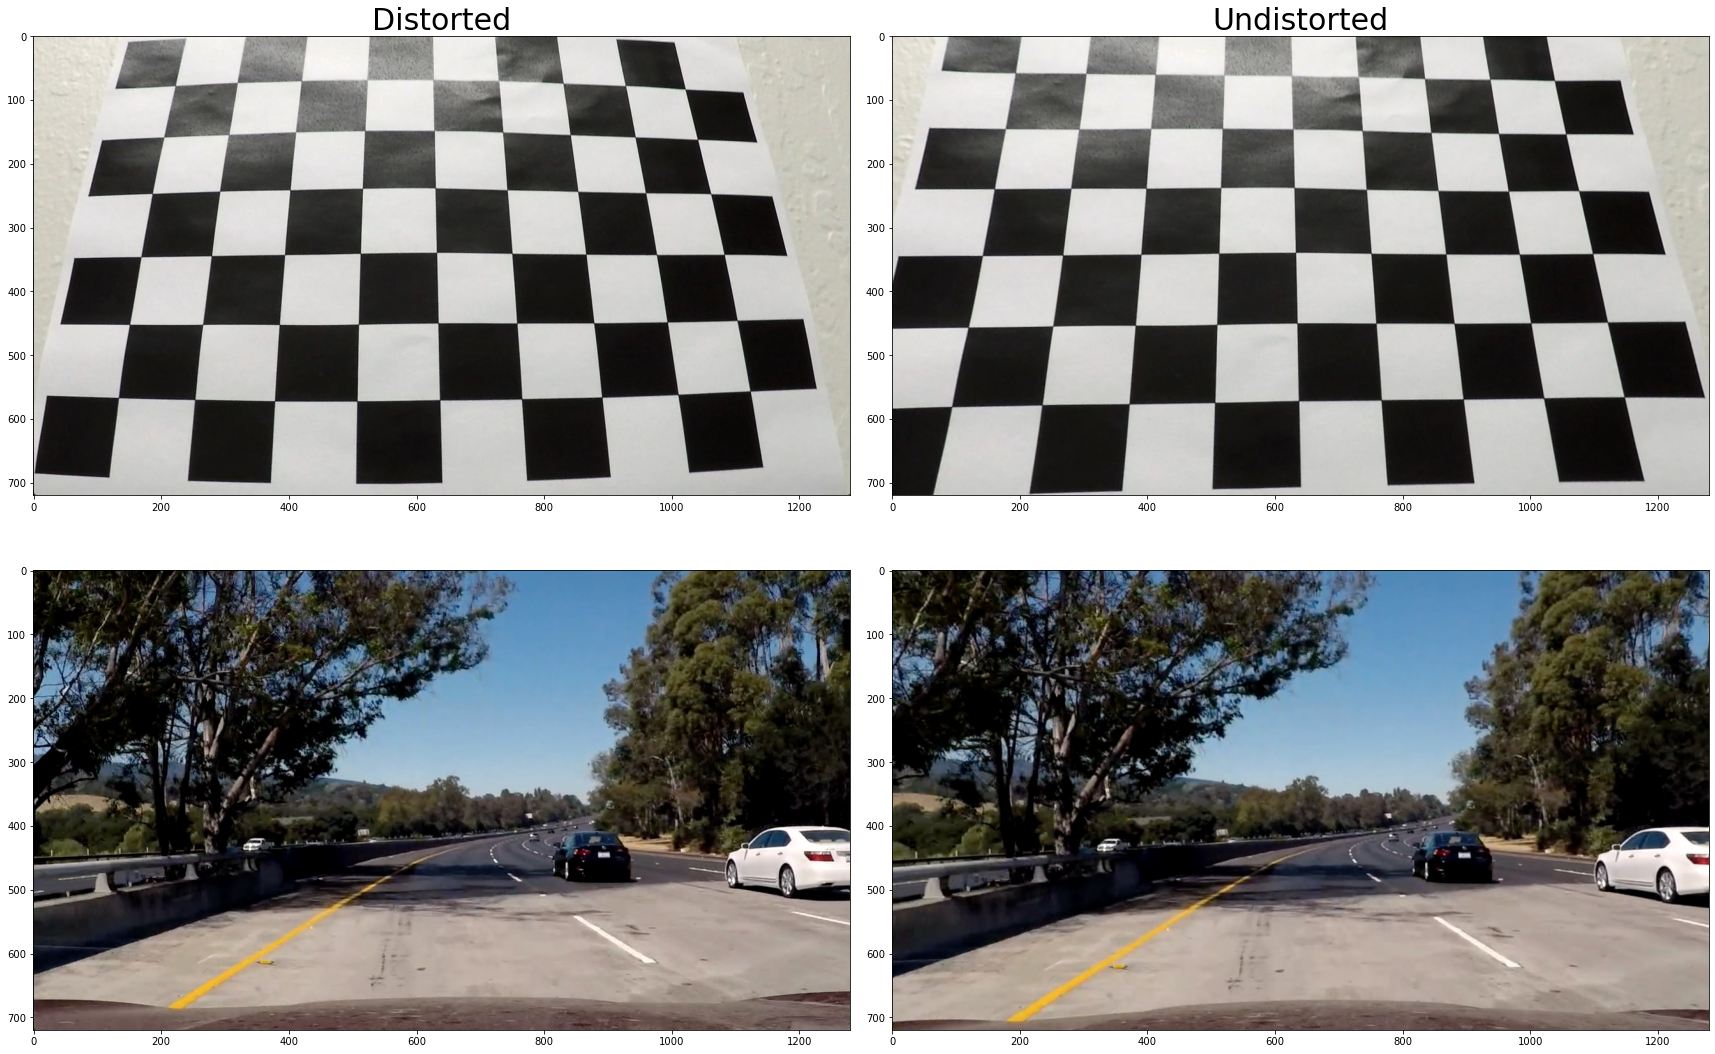

In [236]:
f, axarr = plt.subplots(2,2, figsize=(24, 15))
f.tight_layout()
axarr[0,0].set_title("Distorted", fontsize=30)
axarr[0,1].set_title("Undistorted", fontsize=30)

img = mpimg.imread("./camera_cal/calibration3.jpg")
dst = cv2.undistort(img, mtx, dist, None, mtx)
mpimg.imsave("./output_images/undistorted/calibration3.jpg", dst)
axarr[0,0].imshow(img)
axarr[0,1].imshow(dst)

img = mpimg.imread("./test_images/test5.jpg")
dst = cv2.undistort(img, mtx, dist, None, mtx)
axarr[1,0].imshow(img)
axarr[1,1].imshow(dst)

## 3. Gradient and Color Thresholds to Create a Binary Image

In [4]:
def mag_threshold(img, sobel_kernel=3, mag_thresh=(20, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobelx ** 2 + sobely ** 2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0.7, 1.3)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(grad_dir)
    binary_output[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def threshold(img, s_thresh=(120, 255)):
    img = np.copy(img)
    # Threshold gradient
    mag_binary = mag_threshold(img)
    dir_binary = dir_threshold(img)
    sobel_binary = np.zeros_like(mag_binary)
    sobel_binary[(mag_binary == 1) & (dir_binary == 1)] = 1
    
    # Threshold color channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    l_binary = np.zeros_like(s_channel)
    s_binary[(s_thresh[0] <= s_channel) & (s_channel <= s_thresh[1])] = 1
    l_binary[(s_thresh[0] <= l_channel) & (l_channel <= s_thresh[1])] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sobel_binary)
    combined_binary[(s_binary & l_binary == 1) | (sobel_binary == 1)] = 1
    
    return combined_binary

### 3.1 TO-DO
1. absolute sobel (root of sum of squares of x and y sobels)
2. gradient direction thresholding to ignore lines that are not almost vertical

## 4. Perspective Transform
We do this in order to get a top-down view of the lane which will help in calculating the curvature later in Section 6.

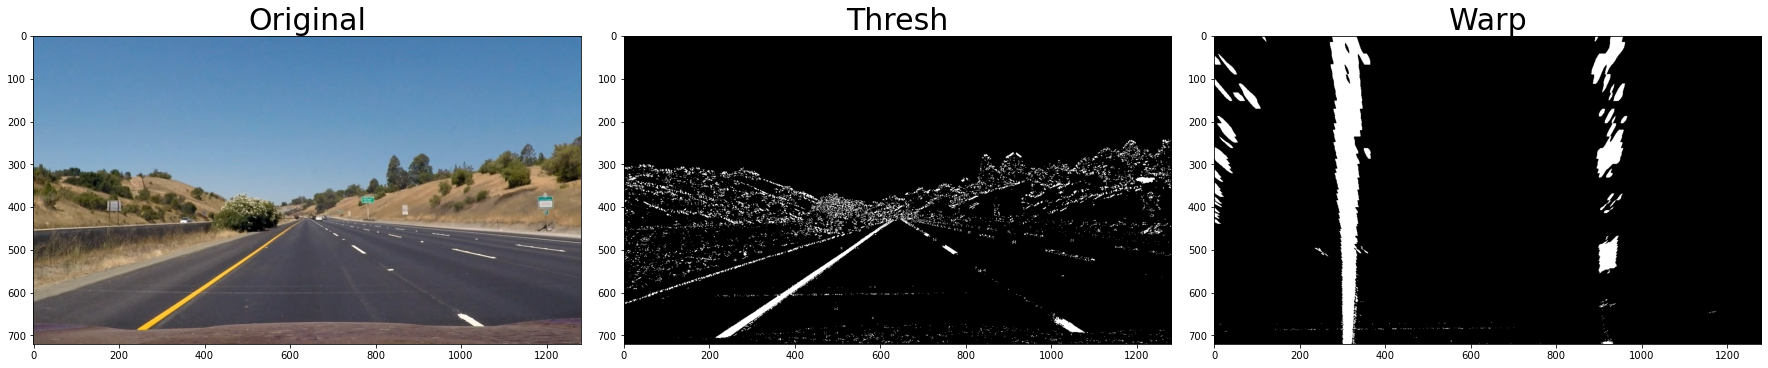

In [5]:
# Specify source points from a test image with straight lane lines (straight_lines1.jpg)
straight_img = mpimg.imread("./test_images/straight_lines1.jpg")
straight_undist = cv2.undistort(straight_img, mtx, dist, None, mtx)
straight_thresh = threshold(straight_undist, (120, 255))
x_max = straight_img.shape[1]
y_max = straight_img.shape[0]
# Don't change these src and dst values. It took 15 minutes of trial and error to perfect them.
src_points = np.float32([[596,449],[684,449],[1054,678],[253,678]]) # clockwise starting from top left
dst_points = np.float32([[300,0],[930,0],[930,y_max],[300,y_max]])

# Calculate warp matrix and do the perspective transform
M = cv2.getPerspectiveTransform(src_points, dst_points)
M_inv = cv2.getPerspectiveTransform(dst_points, src_points)
straight_warped = cv2.warpPerspective(straight_thresh, M, (x_max, y_max), flags=cv2.INTER_LINEAR)

# Plot the result
f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax0.imshow(straight_img)
ax0.set_title('Original', fontsize=30)
ax1.imshow(straight_thresh, cmap='gray')
ax1.set_title('Thresh', fontsize=30)
ax2.imshow(straight_warped, cmap='gray')
ax2.set_title('Warp', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### 4.1 Test perspective transform on curved lane

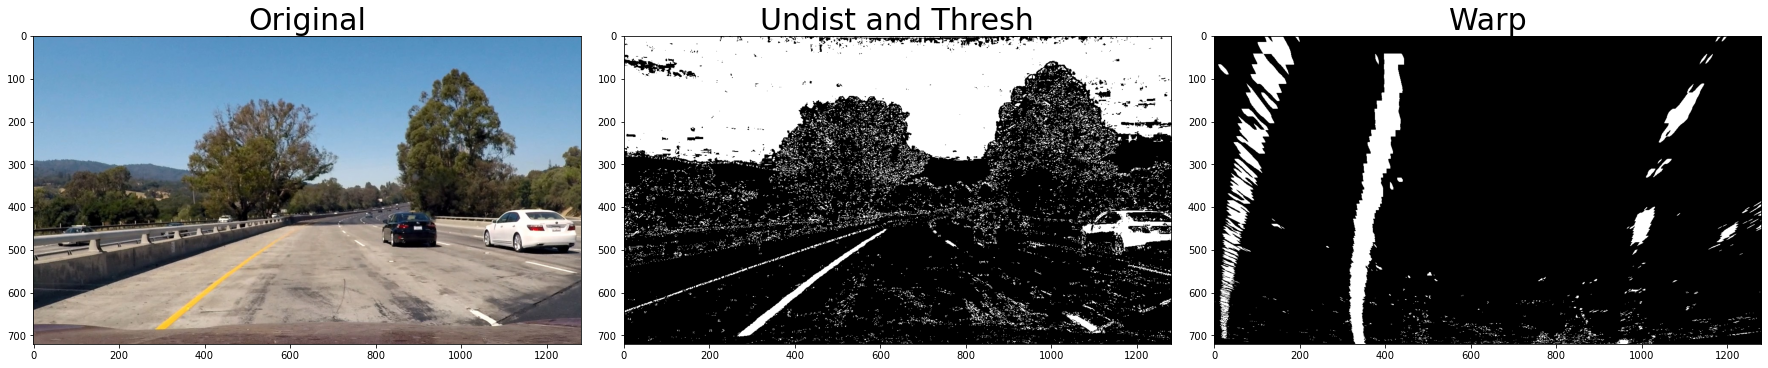

In [228]:
curved_img = mpimg.imread("./test_images/test1.jpg")
curved_undist = cv2.undistort(curved_img, mtx, dist, None, mtx)
curved_thresh = threshold(curved_undist)
binary_warped = cv2.warpPerspective(curved_thresh, M, (x_max, y_max), flags=cv2.INTER_LINEAR)

# Plot the result
f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax0.imshow(curved_img)
ax0.set_title('Original', fontsize=30)
ax1.imshow(curved_thresh, cmap='gray')
ax1.set_title('Undist and Thresh', fontsize=30)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Warp', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 5. Detect Lane Lines

### 5.1 Sliding Window Method for the first frame

CPU times: user 59.1 ms, sys: 6.83 ms, total: 65.9 ms
Wall time: 67.2 ms


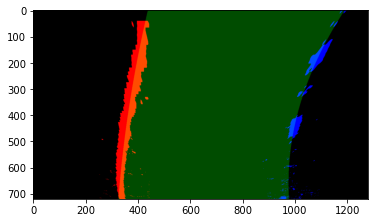

In [229]:
%%time
def get_lane_fits_sw(binary_warped):
    """
    Get lane equations (left and right fits) using sliding window (sw) method
    """

    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0]) # row numbers
    nonzerox = np.array(nonzero[1]) # column numbers

    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        '''
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        '''

        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = []
        good_right_inds = []
        
        # PERFORMANCE IMPROVEMENT
        # instead of looping over all of nonzeroy
        # only look at the y values in the current window
        # 586 ms --> 114 ms (over 5x improvement)
        start_ind_y = np.searchsorted(nonzeroy, win_y_low, side='left')
        end_ind_y = np.searchsorted(nonzeroy, win_y_high, side='left')
        
        x_slice = nonzerox[start_ind_y:end_ind_y]
        #print("len(x_slice) =",len(x_slice))
        #print("x_slice sorted?", np.all(np.diff(x_slice) >= 0))
        x_slice_p = np.argsort(x_slice)
        x_slice_sorted = x_slice[x_slice_p]
        start_ind_xl = np.searchsorted(x_slice_sorted, win_xleft_low, side='left')
        end_ind_xl   = np.searchsorted(x_slice_sorted, win_xleft_high, side='left')
        start_ind_xr = np.searchsorted(x_slice_sorted, win_xright_low, side='left')
        end_ind_xr   = np.searchsorted(x_slice_sorted, win_xright_high, side='left')
        good_left_inds  = [i+start_ind_y for i in x_slice_p[list(range(start_ind_xl, end_ind_xl))]]
        good_right_inds = [i+start_ind_y for i in x_slice_p[list(range(start_ind_xr, end_ind_xr))]]
        #print("start_ind_y =", start_ind_y)
        #print("end_ind_y =", end_ind_y)
        #print("start_ind_xl =", start_ind_xl)
        #print("end_ind_xl =", end_ind_xl)
        #print("start_ind_xr =", start_ind_xr)
        #print("end_ind_xr =", end_ind_xr)
        #print("quick good_left_inds =", len(good_left_inds))
        #print("quick good_right_inds =", len(good_right_inds))
        '''
        
        good_left_inds = []
        good_right_inds = []
        for i in range(start_ind_y, end_ind_y):
            x = nonzerox[i]
            y = nonzeroy[i]
            if win_xleft_low <= x < win_xleft_high:
                good_left_inds.append(i)
            if win_xright_low <= x < win_xright_high:
                good_right_inds.append(i)
        '''
        
        # Extend these indices to the lists
        left_lane_inds.extend(good_left_inds)
        right_lane_inds.extend(good_right_inds)

        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = int(np.average(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = int(np.average(nonzerox[good_right_inds]))

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    # Create an image to draw on and an image to show the selection window
    tmp_img = np.zeros_like(binary_warped)
    out_img = np.dstack((tmp_img, tmp_img, tmp_img))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    #right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    #right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    #right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    #cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.imshow(result)

    return left_fit, right_fit, result

left_fit, right_fit, result = get_lane_fits_sw(binary_warped)
plt.imshow(result)

### 5.2 Detect lanes based on previous frame's equations

CPU times: user 88.6 ms, sys: 3.97 ms, total: 92.6 ms
Wall time: 92.8 ms


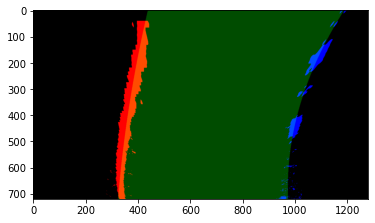

In [230]:
%%time
def get_lane_fits_sa(binary_warped, plf, prf):
    """
    Get lane fit equations with the search around method
    which uses fit equations from previous frame
    """
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 50

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    p_lf = np.poly1d(plf)
    p_rf = np.poly1d(prf)
    left_lane_inds = []
    right_lane_inds = []
    
    # Pre-calculating left and right x values for all y values
    # This made get_lane_fits_sa function more than 24 times faster
    for i in range(binary_warped.shape[0]):
        pxl = p_lf(i)
        pxr = p_rf(i)
        start_ind_y = np.searchsorted(nonzeroy, i, side='left')
        end_ind_y = np.searchsorted(nonzeroy, i+1, side='left')
        x_slice = nonzerox[start_ind_y:end_ind_y]
        #print(x_slice)
        #print("len(x_slice) =",len(x_slice))
        #print("x_slice sorted?", np.all(np.diff(x_slice) >= 0))
        x_slice_p = np.argsort(x_slice)
        x_slice_sorted = x_slice[x_slice_p]
        #print(x_slice_sorted)
        start_ind_xl = np.searchsorted(x_slice_sorted, pxl-margin, side='left')
        end_ind_xl   = np.searchsorted(x_slice_sorted, pxl+margin, side='left')
        start_ind_xr = np.searchsorted(x_slice_sorted, pxr-margin, side='left')
        end_ind_xr   = np.searchsorted(x_slice_sorted, pxr+margin, side='left')
        #print("start_ind_y =", start_ind_y)
        #print("end_ind_y =", end_ind_y)
        #print("start_ind_xl =", start_ind_xl)
        #print("end_ind_xl =", end_ind_xl)
        #print("start_ind_xr =", start_ind_xr)
        #print("end_ind_xr =", end_ind_xr)
        left_lane_inds.extend([i+start_ind_y for i in x_slice_p[list(range(start_ind_xl, end_ind_xl))]])
        right_lane_inds.extend([i+start_ind_y for i in x_slice_p[list(range(start_ind_xr, end_ind_xr))]])
        
    #print(len(left_lane_inds))
    #print(len(right_lane_inds))
    #print(lx_store[0:10])
    '''
    for i in range(len(nonzeroy)):
        previous_lx = lx_store[nonzeroy[i]]
        previous_rx = rx_store[nonzeroy[i]]
        if ((previous_lx - margin) < nonzerox[i] < (previous_lx + margin)):
            left_lane_inds.append(i)
        if ((previous_rx - margin) < nonzerox[i] < (previous_rx + margin)):
            right_lane_inds.append(i)
    '''
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a new second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    # Create an image to draw on and an image to show the selection window
    tmp_img = np.zeros_like(binary_warped)
    out_img = np.dstack((tmp_img, tmp_img, tmp_img))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    #right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    #right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    #right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    #cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.imshow(result)

    return left_fit, right_fit, result

new_left_fit, new_right_fit, result = get_lane_fits_sa(binary_warped, left_fit, right_fit)
plt.imshow(result)

## 6.1. Calculate radius of curvature and offset from lane center

In [132]:
def measure_curvature_real(binary_warped, left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/630 # meters per pixel in x dimension (from warp section: 930-300=630)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### Implement the calculation of R_curve (radius of curvature) #####
    y = y_eval * ym_per_pix
    A = left_fit_cr[0]
    B = left_fit_cr[1]
    left_curverad = (1+(2*A*y + B)**2)**(3/2)/(abs(2*A))
    A = right_fit_cr[0]
    B = right_fit_cr[1]
    right_curverad = (1+(2*A*y + B)**2)**(3/2)/(abs(2*A))
    
    return left_curverad, right_curverad

# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real(binary_warped, new_left_fit, new_right_fit)

print(left_curverad, 'm', right_curverad, 'm')

65960.97527394371 m 14936.18831864641 m


In [133]:
def measure_offset_real(binary_warped, left_fit, right_fit):
    xm_per_pix = 3.7/630
    p_lf = np.poly1d(left_fit)
    p_rf = np.poly1d(right_fit)
    y_eval = binary_warped.shape[0]-1
    x_left = p_lf(y_eval)
    x_right = p_rf(y_eval)
    image_mid = binary_warped.shape[1]//2
    lane_mid = (x_left + x_right)//2
    offset = (lane_mid - image_mid)*xm_per_pix
    return offset

## 6.2. Draw lanes on original image

In [134]:
def draw_lanes_orig(orig_img, warped_lanes, M_inv, left_curverad, right_curverad, offset):
    x_max = orig_img.shape[1]
    y_max = orig_img.shape[0]
    warped_lanes = cv2.warpPerspective(warped_lanes, M_inv, (x_max, y_max), flags=cv2.INTER_LINEAR)
    result = cv2.addWeighted(orig_img, 1, warped_lanes, 0.7, 0)

    font      = cv2.FONT_HERSHEY_SIMPLEX
    text1pos  = (50,100)
    text2pos  = (50,150)
    fontScale = 1
    fontColor = (255,255,255)
    lineType  = 2

    avg_curverad = np.around((left_curverad + right_curverad) // 2, 0)
    text1 = 'Radius of curvature = ' + str(int(avg_curverad)) + ' m'
    direction = 'left' if offset < 0 else 'right'
    text2 = 'Vehicle is ' + str(np.around(abs(offset), 2)) + 'm ' + direction + ' of center'
    cv2.putText(result, text1, 
        text1pos, 
        font, 
        fontScale,
        fontColor,
        lineType)
    cv2.putText(result, text2, 
        text2pos, 
        font, 
        fontScale,
        fontColor,
        lineType)
    return result

## 7. Loop all test images through the pipeline

Processing ./test_images/test6.jpg
Processing ./test_images/test5.jpg
Processing ./test_images/test4.jpg
Processing ./test_images/test1.jpg
Processing ./test_images/test3.jpg
Processing ./test_images/test2.jpg
Processing ./test_images/straight_lines2.jpg
Processing ./test_images/straight_lines1.jpg


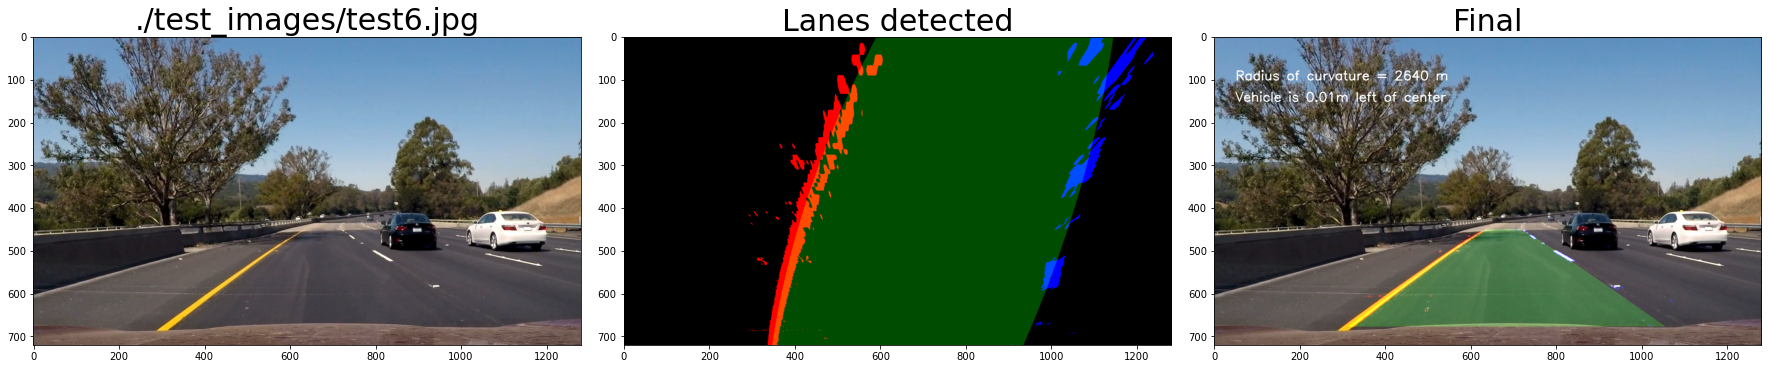

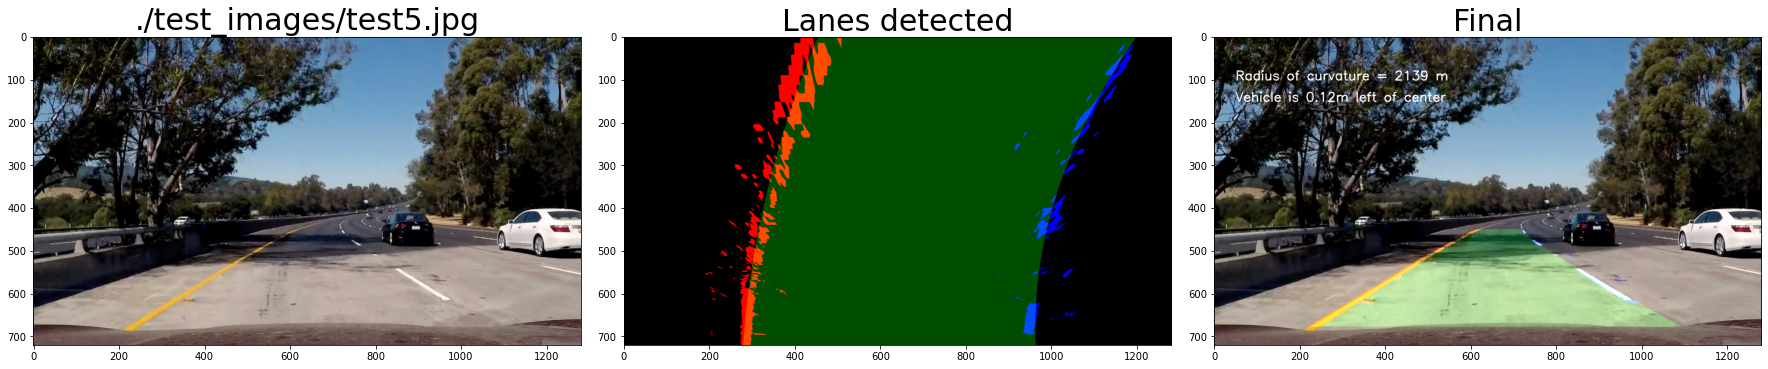

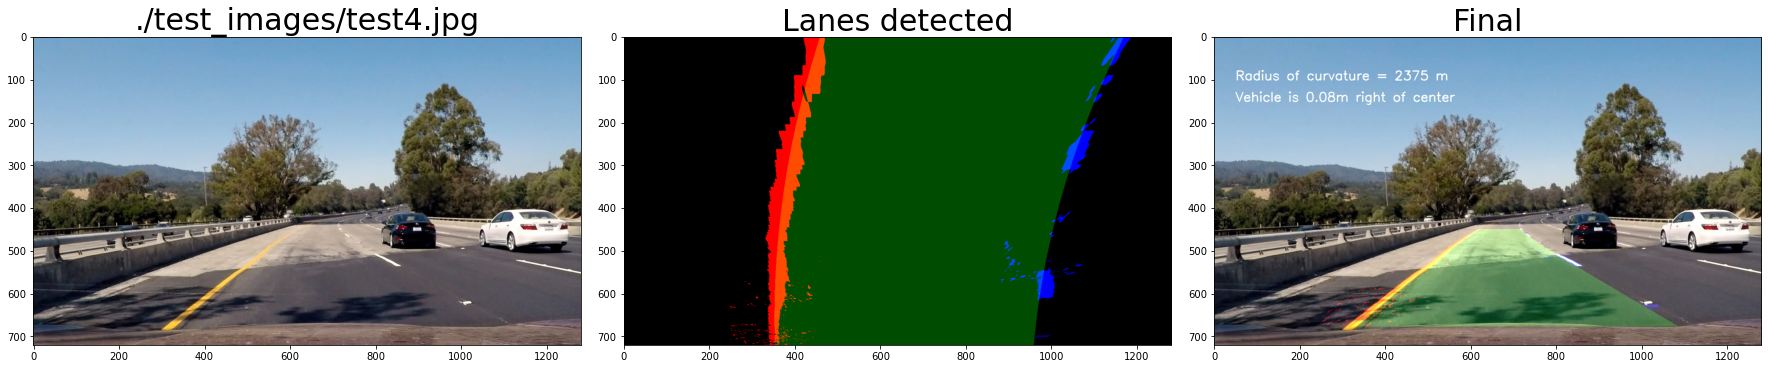

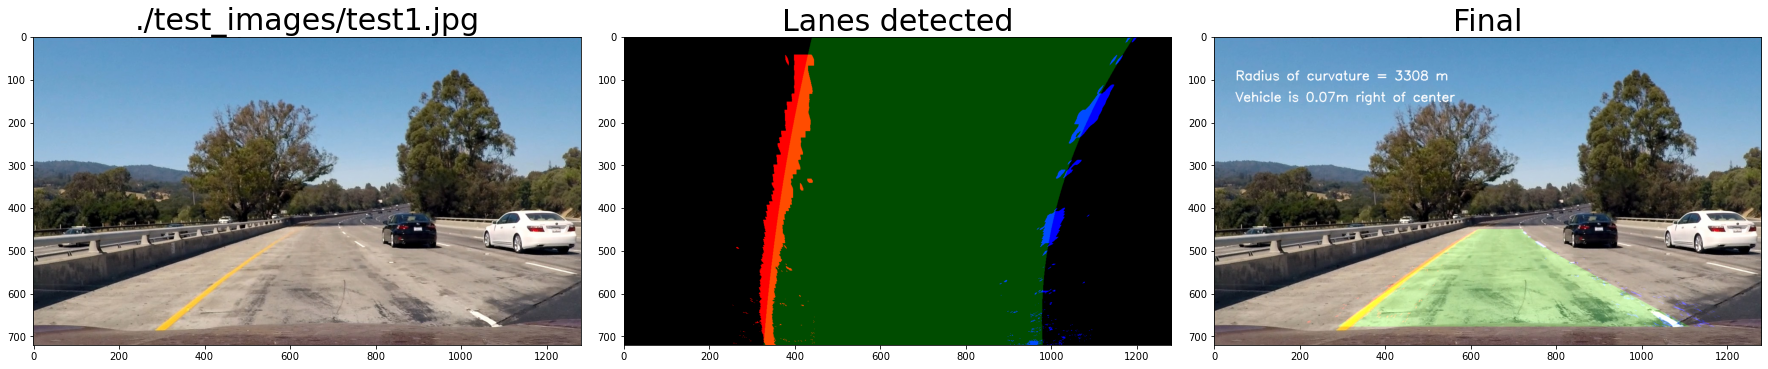

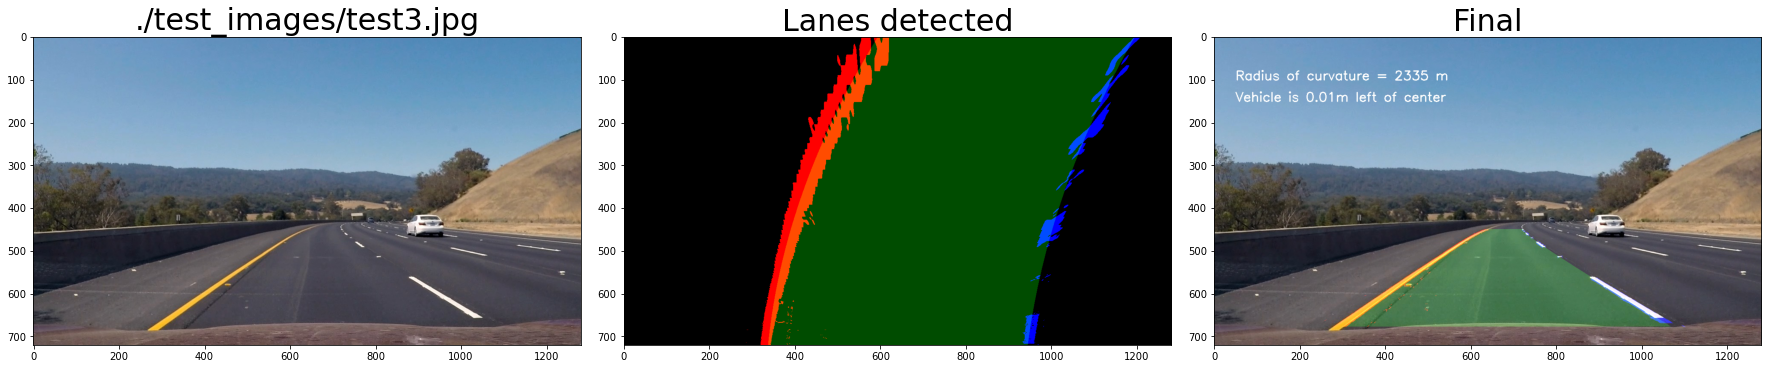

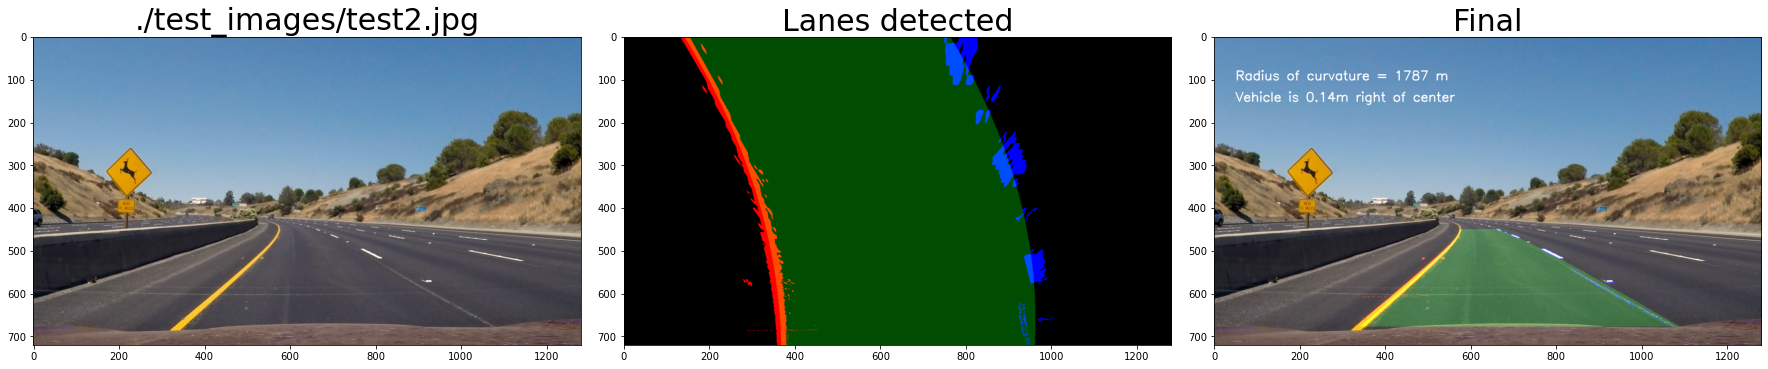

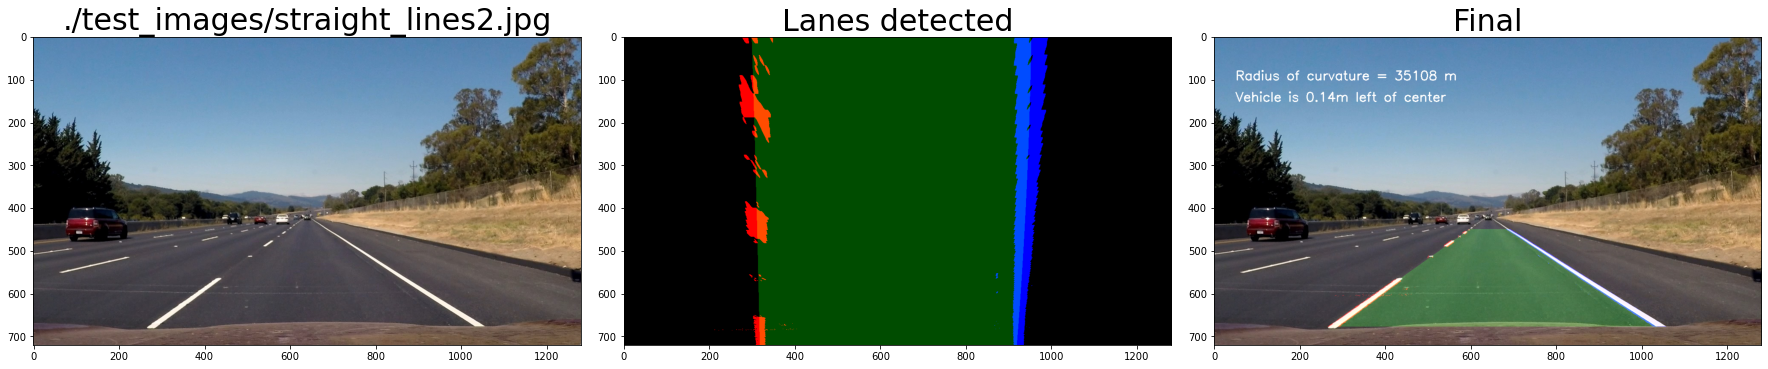

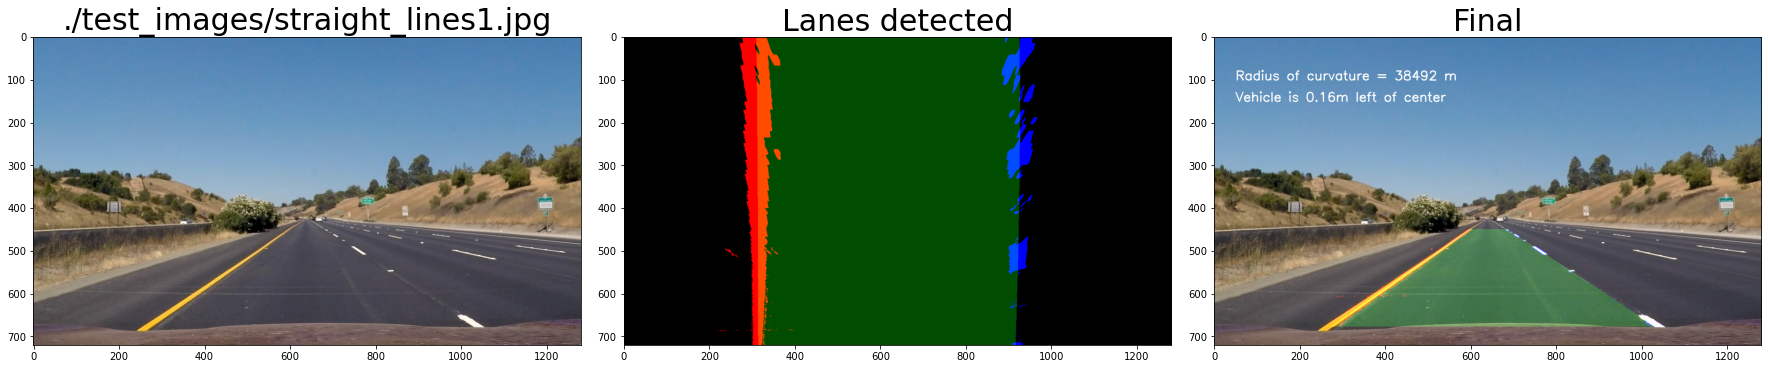

In [237]:
# This code assumes mtx, dist, M and M_inv are already calculated
import os
for fname in glob.glob("./test_images/*.jpg"):
    print("Processing", fname)
    curved_img = mpimg.imread(fname)
    curved_undist = cv2.undistort(curved_img, mtx, dist, None, mtx)
    mpimg.imsave("./output_images/undistorted/"+os.path.basename(fname), curved_undist)
    curved_thresh = threshold(curved_undist)
    mpimg.imsave("./output_images/thresh_binary/"+os.path.basename(fname), curved_thresh)
    binary_warped = cv2.warpPerspective(curved_thresh, M, (x_max, y_max), flags=cv2.INTER_LINEAR)
    mpimg.imsave("./output_images/warped/"+os.path.basename(fname), binary_warped)
    left_fit, right_fit, result = get_lane_fits_sw(binary_warped)
    mpimg.imsave("./output_images/warped_lanes/"+os.path.basename(fname), result)
    left_curverad, right_curverad = measure_curvature_real(binary_warped, left_fit, right_fit)
    offset = measure_offset_real(binary_warped, left_fit, right_fit)
    final_image = draw_lanes_orig(curved_img, result, M_inv, left_curverad, right_curverad, offset)
    mpimg.imsave("./output_images/final_output/"+os.path.basename(fname), final_image)
    
    # Plot the result
    f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()
    ax0.imshow(curved_img)
    ax0.set_title(fname, fontsize=30)
    ax1.imshow(result, cmap='gray')
    ax1.set_title('Lanes detected', fontsize=30)
    ax2.imshow(final_image, cmap='gray')
    ax2.set_title('Final', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 8. Video 📹

In [232]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import uuid
from pathlib import Path
import json

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    # DEBUG
    #frame_id = str(uuid.uuid4())
    #mpimg.imsave("test_video_frames/frame_" + frame_id + ".jpg", image)
    #print(frame_id)
    curved_undist = cv2.undistort(image, mtx, dist, None, mtx)
    #print("undistorted")
    curved_thresh = threshold(curved_undist)
    #print("thresholded")
    binary_warped = cv2.warpPerspective(curved_thresh, M, (x_max, y_max), flags=cv2.INTER_LINEAR)
    #print("warped")
    if Path('./first_frame.json').exists():
        with open("./first_frame.json", "r") as infile:
            # Reading from json file 
            json_object = json.load(infile)
        left_fit, right_fit, result = get_lane_fits_sa(binary_warped, json_object["left_fit"], json_object["right_fit"])
        # Serializing json  
        dictionary = {"left_fit": left_fit.tolist(), "right_fit": right_fit.tolist()}
        json_object = json.dumps(dictionary, indent = 4) 

        # Writing to sample.json 
        with open("./first_frame.json", "w") as outfile: 
            outfile.write(json_object) 
    else:
        left_fit, right_fit, result = get_lane_fits_sw(binary_warped)
        # Serializing json  
        dictionary = {"left_fit": left_fit.tolist(), "right_fit": right_fit.tolist()}
        json_object = json.dumps(dictionary, indent = 4) 

        # Writing to sample.json 
        with open("./first_frame.json", "w") as outfile: 
            outfile.write(json_object) 
    #print("fits calculated")
    left_curverad, right_curverad = measure_curvature_real(binary_warped, left_fit, right_fit)
    #print("curverad measured")
    offset = measure_offset_real(binary_warped, left_fit, right_fit)
    #print("offset measured")
    final_image = draw_lanes_orig(image, result, M_inv, left_curverad, right_curverad, offset)
    #print("final image ready")
    return final_image

white_output = './project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


                                                           
t:   2%|▏         | 1/50 [11:00<8:59:42, 660.87s/it, now=None]
                                                           
t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]now=None]

Moviepy - Building video ./project_video_output.mp4.
Moviepy - Writing video ./project_video_output.mp4



t:  11%|█         | 140/1260 [00:28<03:48,  4.91it/s, now=None]


Moviepy - Done !
Moviepy - video ready ./project_video_output.mp4
CPU times: user 4min 58s, sys: 51.5 s, total: 5min 49s
Wall time: 5min 20s
